In [56]:
import os.path
from typing import Optional

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from totalsegmentator.map_to_binary import class_map_5_parts

In [57]:
def prepare_data(root: str, fast: bool) -> pd.DataFrame:
    files = [f'0{i}' + ('_fast' if fast else '') + '.csv' for i in range(9)]
    down_factors = ['Original', '0.9', '0.7', '0.5', '0.4', '0.3', '0.2', '0.1', '0.05']
    
    # Load & concat all csvs
    dfs = []
    for file, down_factor in zip(files, down_factors):
        df = pd.read_csv(os.path.join(root, file))
        df = df[(df['ds'] != -1) & (df['nsd'] != -1)]
        df = df.groupby('label_str')[['ds', 'nsd']].mean()
        df['DF'] = down_factor
        dfs.append(df)
    df = pd.concat(dfs).reset_index()
    
    # Get mapping to organ sections
    temp_map = {k: list(v.values()) for k, v in class_map_5_parts.items()}
    class_map = {}
    for k in temp_map.keys():
        class_map.update({v: k.replace('class_map_part_', '') for v in temp_map[k]})
    df['section'] = df['label_str'].map(class_map)
    
    return df


def set_size(width, fraction=1):
    fig_width_pt = width * fraction

    inches_per_pt = 1 / 72.27
    golden_ratio = (5**.5 - 1) / 2

    fig_width_in = fig_width_pt * inches_per_pt
    fig_height_in = fig_width_in * golden_ratio
    return fig_width_in, fig_height_in


def get_boxplot(df: pd.DataFrame, save_path: Optional[str]=None, metric: str = 'ds', loc = 'best') -> None:
    tex_fonts = {
        "text.usetex": True,
        "font.family": "serif",
        "font.serif": ['Computer Modern'],
        "axes.labelsize": 10,
        "font.size": 10,
        "legend.fontsize": 8,
        "xtick.labelsize": 8,
        "ytick.labelsize": 8
    }
    sns.set(rc=tex_fonts)
    sns.set_style('whitegrid', rc=tex_fonts)
    
    jama_palette = ['#374E555F', '#DF8F44FF', '#00A1D5FF', '#B24745FF', '#79AF97FF', '#6A6599FF', '#907965BFF']
        
    fig_dims = set_size(300)
    fig_dims = (fig_dims[0] * 1.1, fig_dims[1])
    fig, ax = plt.subplots(figsize=fig_dims)
    ax.tick_params(bottom=True, left=True, color='#bbbbbb')
    ax = sns.boxplot(
        x='DF',
        y=metric,
        hue='section',
        data=df,
        hue_order=['organs', 'vertebrae', 'cardiac', 'muscles', 'ribs'],
        fliersize=0,
        palette=jama_palette,
    )
    sns.despine()
    ax.set_ylim(0, 1)
    
    ax.set_xlabel('Downsampling Factor [DF]')
    ax.set_ylabel('Dice Score' if metric == 'ds' else 'NSD')
    ax.legend(title='', loc=loc)
    
    if save_path is not None:
        plt.savefig(save_path, bbox_inches='tight')
    plt.show()
    plt.close()
    

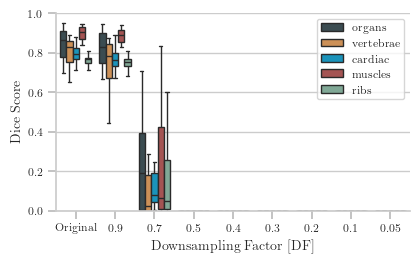

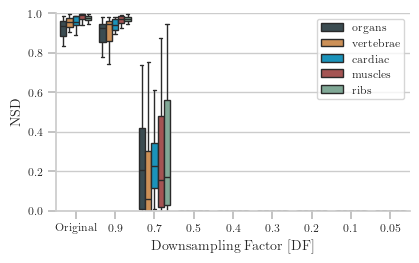

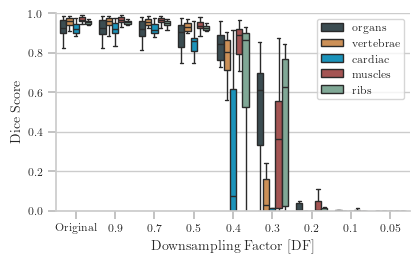

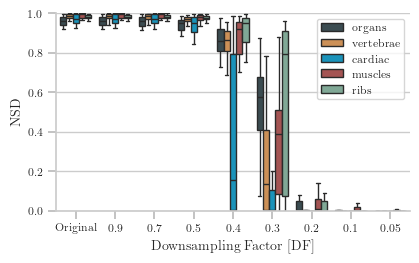

In [58]:
df = prepare_data('../plots/results_grid_zero', True)
get_boxplot(df, '../plots/dice_section_zero_fast.pdf', 'ds')
get_boxplot(df, '../plots/nsd_section_zero_fast.pdf', 'nsd', True)

df = prepare_data('../plots/results_grid_zero', False)
get_boxplot(df, '../plots/dice_section_zero.pdf', 'ds')
get_boxplot(df, '../plots/nsd_section_zero.pdf', 'nsd')

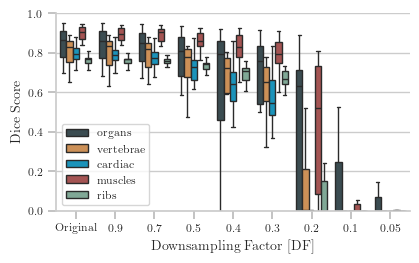

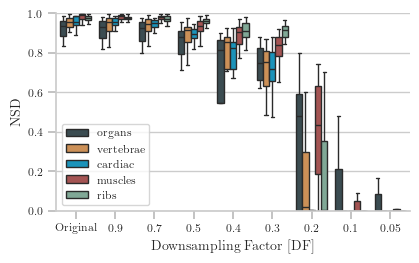

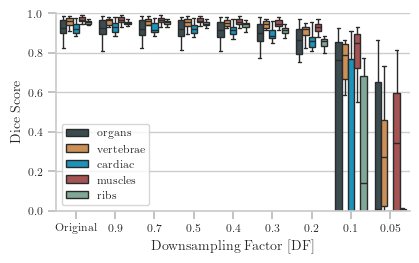

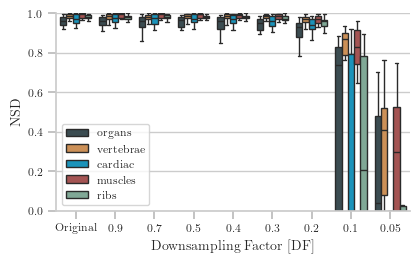

In [59]:
df = prepare_data('../plots/results_grid_fine', True)
get_boxplot(df, '../plots/dice_section_fine_fast.pdf', 'ds', 'lower left')
get_boxplot(df, '../plots/nsd_section_fine_fast.pdf', 'nsd', 'lower left')

df = prepare_data('../plots/results_grid_fine', False)
get_boxplot(df, '../plots/dice_section_fine.pdf', 'ds', 'lower left')
get_boxplot(df, '../plots/nsd_section_fine.pdf', 'nsd', 'lower left')

In [60]:
def get_lineplot(df: pd.DataFrame, save_path: Optional[str]=None, metric: str = 'ds', loc = 'best') -> None:
    tex_fonts = {
        "text.usetex": True,
        "font.family": "serif",
        "font.serif": ['Computer Modern'],
        "axes.labelsize": 10,
        "font.size": 10,
        "legend.fontsize": 8,
        "xtick.labelsize": 8,
        "ytick.labelsize": 8
    }
    sns.set(rc=tex_fonts)
    sns.set_style('whitegrid', rc=tex_fonts)
    
    jama_palette = ['#374E555F', '#DF8F44FF', '#00A1D5FF', '#B24745FF', '#79AF97FF', '#6A6599FF', '#907965BFF']
    
    fig_dims = set_size(300)
    fig_dims = (fig_dims[0], fig_dims[1] * 0.8)
    fig, ax = plt.subplots(figsize=fig_dims)
    ax.tick_params(bottom=True, left=True, color='#bbbbbb')
    ax = sns.lineplot(
        x='DF',
        y=metric,
        hue='strat',
        data=df,
        palette=jama_palette,
        marker="o",
        err_style='bars',
        errorbar=('sd', 1),
        err_kws={'capsize': 2.5},
    )
    sns.despine()
    ax.set_ylim(0, 1)
    ax.xaxis.grid(False)
    
    for line in ax.lines:
        line.set_alpha(1)
    for bar in ax.collections:
        bar.set_alpha(1) 
    
    ax.set_xlabel('Downsampling Factor [DF]')
    ax.set_ylabel('Dice Score' if metric == 'ds' else 'NSD')
    ax.legend(title='', loc=loc)
    
    if save_path is not None:
        plt.savefig(save_path, bbox_inches='tight')
    plt.show()
    plt.close()

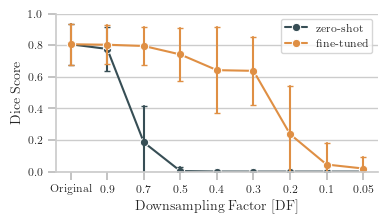

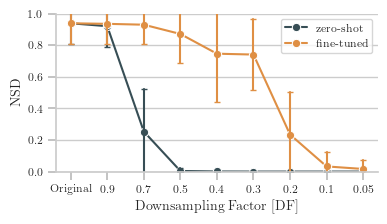

In [61]:
df_zero = prepare_data('../plots/results_grid_zero', True)
df_zero['strat'] = 'zero-shot'
df_fine = prepare_data('../plots/results_grid_fine', True)
df_fine['strat'] = 'fine-tuned'
df = pd.concat([df_zero, df_fine])

#get_lineplot(df, '../plots/dice_overview_fast.pdf', 'ds')
#get_lineplot(df, '../plots/nsd_overview_fast.pdf', 'nsd')

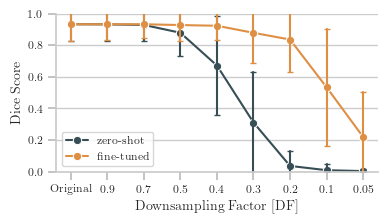

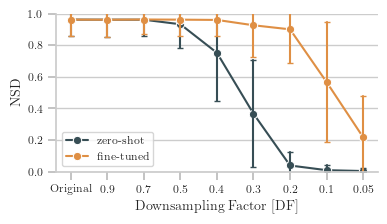

In [62]:
df_zero = prepare_data('../plots/results_grid_zero', False)
df_zero['strat'] = 'zero-shot'
df_fine = prepare_data('../plots/results_grid_fine', False)
df_fine['strat'] = 'fine-tuned'
df = pd.concat([df_zero, df_fine])

#get_lineplot(df, '../plots/dice_overview.pdf', 'ds')
#get_lineplot(df, '../plots/nsd_overview.pdf', 'nsd')

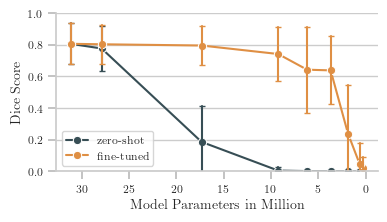

In [65]:
def get_lineplot(df: pd.DataFrame, save_path: Optional[str]=None, metric: str = 'ds', loc = 'best') -> None:
    tex_fonts = {
        "text.usetex": True,
        "font.family": "serif",
        "font.serif": ['Computer Modern'],
        "axes.labelsize": 10,
        "font.size": 10,
        "legend.fontsize": 8,
        "xtick.labelsize": 8,
        "ytick.labelsize": 8
    }
    sns.set(rc=tex_fonts)
    sns.set_style('whitegrid', rc=tex_fonts)
    
    jama_palette = ['#374E555F', '#DF8F44FF', '#00A1D5FF', '#B24745FF', '#79AF97FF', '#6A6599FF', '#907965BFF']
    
    fig_dims = set_size(300)
    fig_dims = (fig_dims[0], fig_dims[1] * 0.8)
    fig, ax = plt.subplots(figsize=fig_dims)
    ax.tick_params(bottom=True, left=True, color='#bbbbbb')
    ax = sns.lineplot(
        x='m_params',
        y=metric,
        hue='strat',
        data=df,
        palette=jama_palette,
        marker="o",
        err_style='bars',
        errorbar=('sd', 1),
        err_kws={'capsize': 2.5},
    )
    sns.despine()
    ax.set_ylim(0, 1)
    ax.xaxis.grid(False)
    
    plt.gca().invert_xaxis()
    
    for line in ax.lines:
        line.set_alpha(1)
    for bar in ax.collections:
        bar.set_alpha(1) 
    
    ax.set_xlabel('Model Parameters in Million')
    ax.set_ylabel('Dice Score' if metric == 'ds' else 'NSD')
    ax.legend(title='', loc=loc)
    
    if save_path is not None:
        plt.savefig(save_path, bbox_inches='tight')
    plt.show()
    plt.close()

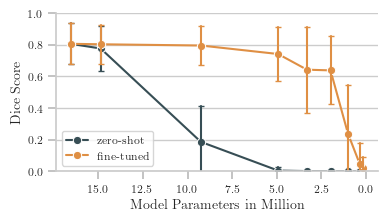

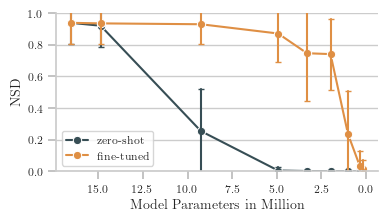

In [66]:
pairing_dict = {
  'Original': 16.55,
  '0.9': 14.87,
  '0.7': 9.25,
  '0.5': 4.92,
  '0.4': 3.3,
  '0.3': 1.98,
  '0.2': 1.0,
  '0.1': 0.34,
  '0.05': 0.15
}
    
df_zero = prepare_data('../plots/results_grid_zero', True)
df_zero['strat'] = 'zero-shot'
df_fine = prepare_data('../plots/results_grid_fine', True)
df_fine['strat'] = 'fine-tuned'
df = pd.concat([df_zero, df_fine])

df['m_params'] = df['DF'].map(pairing_dict)

get_lineplot(df, '../plots/dice_overview_fast.pdf', 'ds')
get_lineplot(df, '../plots/nsd_overview_fast.pdf', 'nsd')

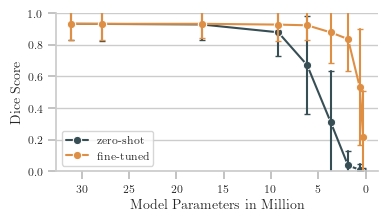

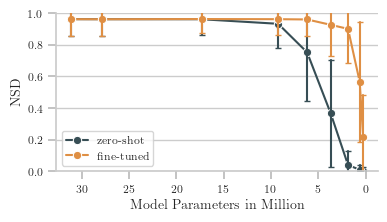

In [68]:
pairing_dict = {
    'Original': 31.19,
    '0.9': 27.92,
    '0.7': 17.35,
    '0.5': 9.24,
    '0.4': 6.18,
    '0.3': 3.69,
    '0.2': 1.85,
    '0.1': 0.62,
    '0.05': 0.25
}
    
df_zero = prepare_data('../plots/results_grid_zero', False)
df_zero['strat'] = 'zero-shot'
df_fine = prepare_data('../plots/results_grid_fine', False)
df_fine['strat'] = 'fine-tuned'
df = pd.concat([df_zero, df_fine])

df['m_params'] = df['DF'].map(pairing_dict)

get_lineplot(df, '../plots/dice_overview.pdf', 'ds')
get_lineplot(df, '../plots/nsd_overview.pdf', 'nsd')